## Visualization libraries & Imports

In [1]:
from IPython.display import Image, HTML

In [3]:
!pip install gitpython

In [4]:
!pip install -q git+https://github.com/tensorflow/docs

  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [4]:
!pip install -q imageio
!pip install -q opencv-python

In [6]:
!pip install tensorflow_hub

In [7]:
!pip install tensorflow-docs

ERROR: Ignored the following versions that require a different python version: 2023.5.24.56664 Requires-Python >=3.9; 2024.2.5.73858 Requires-Python >=3.9; 2025.2.12.60881 Requires-Python >=3.9; 2025.2.19.33219 Requires-Python >=3.9
ERROR: Could not find a version that satisfies the requirement tensorflow-docs (from versions: none)
ERROR: No matching distribution found for tensorflow-docs


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
# from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [3]:
print(tf.__version__)

2.11.0


In [4]:
import sys
sys.executable

'c:\\Users\\Intel\\AppData\\Local\\Programs\\Python\\Python37\\python.exe'

In [5]:
!pip freeze > requirements.txt

In [5]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration, dest):
  """Converts image sequence (4D numpy array) to gif."""
  print(dest)
  imageio.mimsave(f'{dest}_animation.gif', images, duration=duration)
  # return embed.embed_file('./animation.gif')
  # return 

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## Load Model from TF hub

In [7]:
module = hub.load("models/regait/")
input_size = 192
def regait(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

# Web Server

In [8]:
#@title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(regait, image, crop_region, crop_size):
  """Runs model inference on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = regait(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores

In [9]:
# app.py
from flask import Flask, render_template, request
import time

import io
import urllib
import base64


import os
from werkzeug.utils import secure_filename



# gait_rules.py
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt

In [10]:
import PIL

In [11]:
from werkzeug.serving import make_server
import threading

In [12]:
app = Flask(__name__)

In [13]:
# ---------- Helpers ----------
def normalize_keypoints(kps, img_width=None, img_height=None):
    """
    kps: (T, 17, 3) array: x, y, confidence (pixel coords)
    returns: (T, 17, 3) normalized to [0,1] using img dims if provided,
             otherwise normalize per-frame by max dims found
    """
    kps = np.array(kps).astype(float)
    if img_width and img_height:
        kps[..., 0] /= img_width
        kps[..., 1] /= img_height
    else:
        # fallback normalize by max observed values
        max_x = np.nanmax(kps[..., 0] + 1e-8)
        max_y = np.nanmax(kps[..., 1] + 1e-8)
        if max_x > 0:
            kps[..., 0] /= max_x
        if max_y > 0:
            kps[..., 1] /= max_y
    return kps

def smooth_signal(sig, win=11, poly=3):
    if len(sig) < win:
        return sig
    return savgol_filter(sig, win, poly)

# ---------- Biomechanical features ----------
def joint_angles_2d(kps, a_idx, b_idx, c_idx):
    """
    Compute angle at joint b formed by points a-b-c in 2D for each frame.
    kps: (T, 17, 3)
    returns: angles in degrees, (T,)
    """
    a = kps[:, a_idx, :2]
    b = kps[:, b_idx, :2]
    c = kps[:, c_idx, :2]
    ba = a - b
    bc = c - b
    # compute angle
    dot = np.sum(ba * bc, axis=1)
    na = np.linalg.norm(ba, axis=1)
    nc = np.linalg.norm(bc, axis=1)
    cosang = dot / (na * nc + 1e-8)
    cosang = np.clip(cosang, -1.0, 1.0)
    ang = np.degrees(np.arccos(cosang))
    return ang

# ---------- Step detection ----------
def detect_step_events(kps, side='x', low_confidence_thresh=0.3, smooth_window=11, prominence=0.02):
    """
    Detect step events using ankle horizontal motion.
    kps: (T, 17, 3)
    side: 'x' or 'y' axis to use (choose axis aligned with walking direction; usually 'x')
    returns: dict: {'left_peaks': [frame indices], 'right_peaks': [frame indices], 'signal_left', 'signal_right'}
    Notes:
      - keypoint indices: 15 = left ankle, 16 = right ankle (COCO order)
    """
    T = kps.shape[0]
    left_ankle = kps[:, 15, :2]
    right_ankle = kps[:, 16, :2]
    axis_idx = 0 if side == 'x' else 1

    # Use confidence to mask bad frames
    conf_left = kps[:, 15, 2]
    conf_right = kps[:, 16, 2]

    sigL = left_ankle[:, axis_idx].copy()
    sigR = right_ankle[:, axis_idx].copy()

    # fill low confidence with linear interp or nan
    sigL[conf_left < low_confidence_thresh] = np.nan
    sigR[conf_right < low_confidence_thresh] = np.nan
    # simple nan interpolation
    def interp_nan(s):
        n = len(s)
        x = np.arange(n)
        mask = np.isfinite(s)
        if mask.sum() < 2:
            return np.zeros_like(s)  # fallback
        return np.interp(x, x[mask], s[mask])
    sigL = interp_nan(sigL)
    sigR = interp_nan(sigR)

    # smooth
    sigL_s = smooth_signal(sigL, win=5) if len(sigL) >= smooth_window else sigL
    sigR_s = smooth_signal(sigR, win=5) if len(sigR) >= smooth_window else sigR

    # compute velocity along axis
    velL = np.gradient(sigL_s)
    velR = np.gradient(sigR_s)

    # find peaks in velocity magnitude suggesting step events (heel strikes or toe-off)
    # we look for positive-to-negative velocity transitions -> peaks in vel magnitude
    peaksL, _ = find_peaks(np.abs(velL), prominence=prominence)
    peaksR, _ = find_peaks(np.abs(velR), prominence=prominence)

    return {
        'left_peaks': peaksL.tolist(),
        'right_peaks': peaksR.tolist(),
        'signal_left': sigL_s,
        'signal_right': sigR_s,
        'velocity_left': velL,
        'velocity_right': velR
    }

# ---------- Core metrics ----------
def compute_cadence(left_peaks, right_peaks, fps):
    """
    Cadence in steps per second (average over both feet)
    left_peaks/right_peaks: lists of frame indices for detected steps
    fps: frames per second of video
    """
    total_steps = len(left_peaks) + len(right_peaks)
    if total_steps < 2:
        return 0.0
    duration_sec = (max(left_peaks + right_peaks) - min(left_peaks + right_peaks)) / float(fps)
    if duration_sec <= 0:
        return 0.0
    steps_per_sec = total_steps / duration_sec
    return steps_per_sec

def compute_step_lengths(kps, left_peaks, right_peaks, img_scale=1.0):
    """
    Approximate step length as horizontal distance between ankles at consecutive opposite foot peaks.
    This is heuristic: left_step_length = distance between right-ankle at previous right peak and left-ankle at next left peak
    Returns median step lengths for left and right (in normalized units)
    """
    left_len = []
    right_len = []
    # assume ankle x coordinate is axis 0
    for i in range(1, len(left_peaks)):
        # compare with previous right peak
        prev_r = None
        # find the right peak nearest before this left_peak
        candidates = [p for p in right_peaks if p < left_peaks[i]]
        if candidates:
            prev_r = candidates[-1]
        if prev_r is not None:
            x_r = kps[prev_r, 16, 0]
            x_l = kps[left_peaks[i], 15, 0]
            left_len.append(np.abs(x_l - x_r) * img_scale)
    for i in range(1, len(right_peaks)):
        candidates = [p for p in left_peaks if p < right_peaks[i]]
        prev_l = candidates[-1] if candidates else None
        if prev_l is not None:
            x_l = kps[prev_l, 15, 0]
            x_r = kps[right_peaks[i], 16, 0]
            right_len.append(np.abs(x_r - x_l) * img_scale)
    left_med = np.median(left_len) if left_len else 0.0
    right_med = np.median(right_len) if right_len else 0.0
    return left_med, right_med, left_len, right_len

def stride_time_variability(peaks, fps):
    """
    Coefficient of variation of stride times (std/mean)
    peaks: list of frame indices for a foot
    """
    if len(peaks) < 3:
        return 0.0
    intervals = np.diff(peaks) / float(fps)
    if np.mean(intervals) == 0:
        return 0.0
    return np.std(intervals) / (np.mean(intervals) + 1e-8)

def knee_flexion_range(kps):
    """
    Knee angle in 2D: Use hip(11/12), knee(13/14), ankle(15/16) indices for COCO
    Returns median ranges for left and right knees in degrees
    """
    left_knee_angles = joint_angles_2d(kps, 11, 13, 15)  # hip-left, knee-left, ankle-left
    right_knee_angles = joint_angles_2d(kps, 12, 14, 16)
    # range per stride/window = max-min across sequence
    left_range = np.nanmax(left_knee_angles) - np.nanmin(left_knee_angles) if left_knee_angles.size else 0.0
    right_range = np.nanmax(right_knee_angles) - np.nanmin(right_knee_angles) if right_knee_angles.size else 0.0
    return left_range, right_range

# ---------- Rule-based decision thresholds ----------
DEFAULT_THRESHOLDS = {
    'cadence_low': 1.4,            # steps per second (approx 84 spm). adjust by population
    'step_asymmetry_ratio': 0.2,   # relative difference >20% considered asymmetric
    'knee_range_low_deg': 30.0,    # knee flexion range less than this considered limited
    'stride_cv_high': 0.2,         # coefficient of variation >20% high variability
    'step_length_min': 0.05        # normalized units: too short
}

def compute_all_metrics(kps, fps, img_width=None, img_height=None, side='x'):
    """
    Master function: takes raw kps array (T,17,3), returns metrics dict
    """
    kps_n = normalize_keypoints(kps, img_width, img_height)
    # detect step events
    # d = detect_step_events(kps_n, side=side)

        #debugg
    d = detect_step_events(kps_n, side='x', prominence=0.005)
    plt.plot(d['signal_left'], label='Left ankle')
    plt.plot(d['signal_right'], label='Right ankle')
    plt.scatter(d['left_peaks'], d['signal_left'][d['left_peaks']], c='r')
    plt.scatter(d['right_peaks'], d['signal_right'][d['right_peaks']], c='g')
    plt.legend()
    plt.xlabel("Frames")
    plt.ylabel("Degrees")
    # plt.show()

    img = io.BytesIO()
    plt.savefig(img, format = 'png')
    plt.clf()
    img.seek(0)
    plot_data = urllib.parse.quote(base64.b64encode(img.read()).decode())
    

    left_peaks = d['left_peaks']
    right_peaks = d['right_peaks']

    cadence = compute_cadence(left_peaks, right_peaks, fps)
    left_len, right_len, left_raws, right_raws = compute_step_lengths(kps_n, left_peaks, right_peaks)
    knee_left_range, knee_right_range = knee_flexion_range(kps_n)
    stride_cv_left = stride_time_variability(left_peaks, fps)
    stride_cv_right = stride_time_variability(right_peaks, fps)

    # asymmetry: relative difference normalized by mean
    if (left_len + right_len) == 0:
        asymmetry = 0.0
    else:
        # use medians
        L = left_len
        R = right_len
        # fallback to medians computed earlier
        Lm = left_len
        Rm = right_len
        # simpler: use medians already returned
        a = np.abs(left_len - right_len) if isinstance(left_len, (int,float)) and isinstance(right_len,(int,float)) else np.abs(left_len - right_len)
        # but we computed left_len and right_len as medians earlier
        # correct usage:
        Lm = left_len
        Rm = right_len
        mean_lr = (Lm + Rm) / 2.0 if (Lm + Rm) > 0 else 0.0
        asymmetry = np.abs(Lm - Rm) / (mean_lr + 1e-8) if mean_lr > 0 else 0.0

    metrics = {
        'cadence_sp_per_s': cadence,
        'step_length_left': left_len,
        'step_length_right': right_len,
        'knee_left_range_deg': knee_left_range,
        'knee_right_range_deg': knee_right_range,
        'stride_cv_left': stride_cv_left,
        'stride_cv_right': stride_cv_right,
        'asymmetry_ratio': asymmetry,
        'num_left_steps': len(left_peaks),
        'num_right_steps': len(right_peaks)
    }
    return metrics, plot_data

# ---------- Feedback generator ----------
def rule_based_feedback(metrics, thresholds=DEFAULT_THRESHOLDS):
    """
    metrics: dict from compute_all_metrics
    thresholds: dict of thresholds
    returns: list of strings feedback
    """
    msgs = []
    # cadence
    if metrics['cadence_sp_per_s'] <= 0:
        msgs.append("Unable to detect reliable steps, recheck video.")
        return msgs

    if metrics['cadence_sp_per_s'] < thresholds['cadence_low']:
        msgs.append(f"Cadence appears low ({metrics['cadence_sp_per_s']:.2f} steps/s). Try increasing step frequency.")

    # step length
    L = metrics['step_length_left']
    R = metrics['step_length_right']
    # if either side is extremely small
    if L < thresholds['step_length_min'] or R < thresholds['step_length_min']:
        msgs.append("Step length is very short. Work on taking longer steps where safe.")
    else:
        msgs.append("Good Step Length!")

    # asymmetry
    if metrics['asymmetry_ratio'] > thresholds['step_asymmetry_ratio']:
        msgs.append(f"Significant step asymmetry detected (ratio {metrics['asymmetry_ratio']:.2f}). Try focusing on balancing left and right steps.")
    else:
        msgs.append("Symmetrical Steps!")

    # knee flexion
    if metrics['knee_left_range_deg'] < thresholds['knee_range_low_deg']:
        msgs.append(f"Left knee flexion range is limited ({metrics['knee_left_range_deg']:.0f}°). Knee bending exercises may help.")
    if metrics['knee_right_range_deg'] < thresholds['knee_range_low_deg']:
        msgs.append(f"Right knee flexion range is limited ({metrics['knee_right_range_deg']:.0f}°).  Knee bending exercises may help.")

    # stride variability
    if metrics['stride_cv_left'] > thresholds['stride_cv_high'] or metrics['stride_cv_right'] > thresholds['stride_cv_high']:
        msgs.append("High stride time variability detected, inconsistent stepping. Practice steady pace walking.")
    else:
        msgs.append("Steady Pace!")

    if not msgs:
        msgs.append("Gait looks within normal bounds for the measured metrics. Good symmetry and cadence observed!")

    return msgs


In [14]:
@app.route('/')
def home():
    """This function runs when a user goes to the home page."""
    return render_template('index.html')

@app.route('/about')
def about():
    """This function runs when a user goes to the /about page."""
    return render_template('about.html')

# @app.route('/shutdown')


@app.route('/analyze', methods=['POST'])
def analyze():
    """This function runs when the user uploads a video."""
    if 'video' not in request.files:
        return "No video file found", 400

    # upload_folder = os.path.join(os.getcwd(),'static')
    upload_folder = 'static'
    app.config['UPLOAD_FOLDER'] = upload_folder
    if not os.path.exists(app.config['UPLOAD_FOLDER']):
        os.makedirs(app.config['UPLOAD_FOLDER'])
    
    video_file = request.files['video']
    print(video_file)
    video_file.save(os.path.join(app.config['UPLOAD_FOLDER'], secure_filename(video_file.filename)))
    print("uploadedsuccessfully")

    # Load the input image.
    # input_vid = 'input/ablume_walking.gif'
    input_vid = os.path.join(app.config['UPLOAD_FOLDER'], secure_filename(video_file.filename))
    image = tf.io.read_file(input_vid)
    image = tf.image.decode_gif(image)      
    # Load the input image.
    num_frames, image_height, image_width, _ = image.shape

    #sinusodial wave
    t = np.linspace(0, 4*np.pi, num_frames)

    with PIL.Image.open(input_vid) as in_img:
        input_duration = in_img.info['duration']

    fps = 1000 / input_duration


    # input_gif = imageio.mimread(input_vid)
    # # Get the total duration (sum of all frame durations in milliseconds)
    # total_duration_ms = sum(frame_meta['duration'] for frame_meta in input_gif.meta_data)
    # # Calculate FPS
    # fps = 1000 * num_frames / total_duration_ms

    # reader = imageio.get_reader(input_vid)
    # # Extract metadata about the GIF
    # meta_data = reader.meta_data
    # # Calculate total duration (sum of all frame durations in milliseconds)
    # total_duration_ms = sum(frame_meta['duration'] for frame_meta in meta_data)
    # # Calculate number of frames
    # num_frames = len(reader)
    # # Calculate FPS
    # fps = 1000 * num_frames / total_duration_ms

    crop_region = init_crop_region(image_height, image_width)

    output_images = []
    bar = display(progress(0, num_frames-1), display_id=True)
    kps_final=[]

    for frame_idx in range(num_frames):
      print(frame_idx)
      keypoints_with_scores = run_inference(regait, image[frame_idx, :, :, :], crop_region,crop_size=[input_size, input_size])
      kps_final.append(keypoints_with_scores[0][0])
      output_images.append(draw_prediction_on_image(image[frame_idx, :, :, :].numpy().astype(np.int32),
      keypoints_with_scores, crop_region=None,
      close_figure=True, output_image_height=300))
      crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
      bar.update(progress(frame_idx, num_frames-1))

    # Prepare gif visualization.
    output = np.stack(output_images, axis=0)
    to_gif(output, duration=(input_duration*num_frames), dest=os.path.join(app.config['UPLOAD_FOLDER'], secure_filename(video_file.filename)))


    # video_file.save(f"uploads\\{video_file.filename}")

    metrics,plot_url = compute_all_metrics(kps_final, fps)
    feedback = rule_based_feedback(metrics)

    print("metrics:", metrics)
    print("feedback:", feedback)

    # video_url = "https://storage.googleapis.com/gtv-videos-bucket/sample/ForBiggerFun.mp4"
    
    # video_url = f"/uploads/{video_file.filename}"
    video_url = os.path.join(app.config['UPLOAD_FOLDER'], f"{secure_filename(video_file.filename)}_animation.gif")

    # Run our mock analysis to get the results
    # metrics_2, feedback, video_url = mock_analysis(video_file)
    
    # Render the results.html page and pass the data into it
    return render_template('results.html', 
                           metrics=metrics, 
                           feedback=feedback, 
                           video_url=video_url,
                           plot_url=plot_url)

### Main Fn

In [ ]:

# if __name__ == "__main__":
    # dummy example: replace with real outputs
    # Suppose we have T frames of shape (T,17,3)
    # T = 200
#     T = num_frames
#     fps = 30
    # Create synthetic simple walk: ankles move sinusoidally along x
#     t = np.linspace(0, 4*np.pi, T)


    # kps = np.zeros((T, 17, 3))
    

    # center x around 0.5, amplitude 0.05
    # kps[:, 15, 0] = 0.5 + 0.05 * np.sin(t)  # left ankle
    # kps[:, 16, 0] = 0.5 + 0.05 * np.sin(t + np.pi)  # right ankle opposite phase
    # kps[:, :, 1] = 0.5  # dummy y
    # kps[:, :, 2] = 1.0  # confidence
    

    
def run_flask():
       app.run(host="0.0.0.0",port="8000",debug=True, use_reloader=False, threaded=True)

# Start Flask in a separate thread
flask_thread = threading.Thread(target=run_flask)
flask_thread.start()

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8000
 * Running on http://192.168.1.5:8000
Press CTRL+C to quit
127.0.0.1 - - [29/Oct/2025 17:45:56] "GET / HTTP/1.1" 200 -


<FileStorage: 'ablume_walking.gif' ('image/gif')>
uploadedsuccessfully


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
static\ablume_walking.gif


127.0.0.1 - - [29/Oct/2025 17:47:29] "POST /analyze HTTP/1.1" 200 -


metrics: {'cadence_sp_per_s': 5.7894736842105265, 'step_length_left': 0.010689243972234252, 'step_length_right': 0.027886330332314746, 'knee_left_range_deg': 57.26118269813102, 'knee_right_range_deg': 79.58055473174254, 'stride_cv_left': 0.3867615281562511, 'stride_cv_right': 0.39528469763893004, 'asymmetry_ratio': 0.891604480507124, 'num_left_steps': 6, 'num_right_steps': 5}
feedback: ['Step length is very short. Work on taking longer steps where safe.', 'Significant step asymmetry detected (ratio 0.89). Try focusing on balancing left and right steps.', 'High stride time variability detected, inconsistent stepping. Practice steady pace walking.']


127.0.0.1 - - [29/Oct/2025 17:47:29] "GET /static/ablume_walking.gif_animation.gif HTTP/1.1" 200 -


In [ ]:
"""
kps = [[[0.4325696 , 0.72318286, 0.19659221],
        [0.42023885, 0.7162673 , 0.18779063],
        [0.42177555, 0.7254956 , 0.19734976],
        [0.42011648, 0.7236995 , 0.24616571],
        [0.4210459 , 0.7453255 , 0.23487319],
        [0.4579931 , 0.74739456, 0.2797437 ],
        [0.46507215, 0.7927283 , 0.23896185],
        [0.46796405, 0.7430913 , 0.17086744],
        [0.53687185, 0.8315012 , 0.11753227],
        [0.44415328, 0.73049283, 0.08415768],
        [0.52826685, 0.8201604 , 0.06685377],
        [0.6723243 , 0.8060097 , 0.31141168],
        [0.6706928 , 0.7959448 , 0.29647478],
        [0.8146569 , 0.88603896, 0.3242815 ],
        [0.7971163 , 0.7294667 , 0.46570987],
        [0.9185838 , 0.9961022 , 0.12519701],
        [0.9679644 , 0.7561626 , 0.36224386]],
 [[0.45198882, 0.66870457, 0.45343998],
        [0.4383243 , 0.6681347 , 0.40891582],
        [0.43911657, 0.6686005 , 0.4128671 ],
        [0.4308028 , 0.6945297 , 0.5847587 ],
        [0.4285919 , 0.69985574, 0.5321417 ],
        [0.4558232 , 0.70369893, 0.5231276 ],
        [0.468881  , 0.77070916, 0.59952843],
        [0.42312512, 0.6350936 , 0.64916545],
        [0.53517133, 0.81238896, 0.22586097],
        [0.38684466, 0.6219534 , 0.3601435 ],
        [0.48578665, 0.79357415, 0.08191701],
        [0.6660282 , 0.75671625, 0.73656696],
        [0.6695236 , 0.7727813 , 0.7675031 ],
        [0.8150713 , 0.7848144 , 0.52625555],
        [0.8064111 , 0.7079361 , 0.8489462 ],
        [0.876855  , 0.9312251 , 0.7756067 ],
        [0.96304023, 0.7642176 , 0.7334634 ]],
 [[0.44712695, 0.5878108 , 0.5356493 ],
        [0.43666786, 0.5837634 , 0.55281836],
        [0.43488947, 0.5854215 , 0.51281273],
        [0.4126575 , 0.5970813 , 0.4623802 ],
        [0.40447608, 0.60754216, 0.36308306],
        [0.4319806 , 0.6364009 , 0.45372868],
        [0.4294302 , 0.68181634, 0.43183842],
        [0.5498253 , 0.66795003, 0.2140295 ],
        [0.5390522 , 0.7044379 , 0.21526156],
        [0.63161767, 0.6263126 , 0.40491593],
        [0.6106311 , 0.6586891 , 0.25482228],
        [0.645087  , 0.6839579 , 0.5465393 ],
        [0.6431893 , 0.70289594, 0.48613527],
        [0.7888619 , 0.6698421 , 0.1047975 ],
        [0.78313917, 0.7312269 , 0.24356754],
        [0.902899  , 0.7288364 , 0.3521544 ],
        [0.9102082 , 0.7542947 , 0.22808355]],
 [[0.43649793, 0.52175635, 0.58099663],
        [0.42381495, 0.5176642 , 0.57520455],
        [0.4243092 , 0.52311647, 0.3952974 ],
        [0.40915918, 0.53615534, 0.40574312],
        [0.40576923, 0.5582125 , 0.27876663],
        [0.44892624, 0.57469696, 0.5643344 ],
        [0.44450468, 0.6201599 , 0.5527975 ],
        [0.56078386, 0.6237353 , 0.31377462],
        [0.5382352 , 0.647269  , 0.1912761 ],
        [0.61395854, 0.5862319 , 0.22029819],
        [0.60603046, 0.6576433 , 0.14522004],
        [0.631283  , 0.61278236, 0.5115219 ],
        [0.6308742 , 0.6479982 , 0.38226497],
        [0.76099074, 0.5504701 , 0.51871014],
        [0.7909037 , 0.6853799 , 0.5241741 ],
        [0.9358708 , 0.55182266, 0.660103  ],
        [0.95221764, 0.7559376 , 0.4221825 ]],
 [[0.44771144, 0.5015527 , 0.28980765],
        [0.4414856 , 0.4928604 , 0.2315914 ],
        [0.43751585, 0.504638  , 0.20478421],
        [0.43257737, 0.494873  , 0.48327878],
        [0.42351553, 0.5372758 , 0.35861012],
        [0.4706101 , 0.5225901 , 0.36823276],
        [0.46710366, 0.583399  , 0.5080693 ],
        [0.5660561 , 0.56589746, 0.32869732],
        [0.55952877, 0.5886388 , 0.31698832],
        [0.6260576 , 0.5787727 , 0.12721097],
        [0.6293353 , 0.62722504, 0.23491374],
        [0.6502619 , 0.5523281 , 0.48999766],
        [0.65089947, 0.6060485 , 0.39979643],
        [0.80686915, 0.52049905, 0.4119049 ],
        [0.8007443 , 0.65995497, 0.30897906],
        [0.9605419 , 0.50593054, 0.5554745 ],
        [0.95840305, 0.7462392 , 0.3470855 ]],
 [[0.46556848, 0.4134438 , 0.25134182],
        [0.45506996, 0.40841475, 0.1587958 ],
        [0.4595026 , 0.42274025, 0.10298681],
        [0.44835857, 0.43151882, 0.17448542],
        [0.453249  , 0.46901113, 0.10600124],
        [0.48993182, 0.46325326, 0.33686334],
        [0.49578175, 0.52443457, 0.24796057],
        [0.5878375 , 0.5288612 , 0.09033147],
        [0.5848928 , 0.53777903, 0.13566118],
        [0.65254563, 0.44649893, 0.22983348],
        [0.6564125 , 0.5489876 , 0.07667673],
        [0.6860744 , 0.50185394, 0.4265691 ],
        [0.68374634, 0.5193998 , 0.28647146],
        [0.81376106, 0.47103295, 0.408618  ],
        [0.82134247, 0.5061859 , 0.26389107],
        [0.96470475, 0.50506526, 0.4857945 ],
        [0.8819645 , 0.6467174 , 0.56276566]],
 [[0.47273785, 0.38231364, 0.38310918],
        [0.46192363, 0.38884068, 0.19352782],
        [0.4651043 , 0.39080772, 0.19090919],
        [0.44513845, 0.40498546, 0.33309066],
        [0.45007402, 0.41741598, 0.24737738],
        [0.47906926, 0.43824312, 0.38445544],
        [0.4854491 , 0.47682044, 0.32983938],
        [0.55200416, 0.42052993, 0.36953804],
        [0.55718744, 0.47505552, 0.13689841],
        [0.6168787 , 0.3836794 , 0.3208936 ],
        [0.6196256 , 0.4451935 , 0.09241413],
        [0.65425235, 0.4630445 , 0.35616866],
        [0.6559985 , 0.47168994, 0.32717755],
        [0.79415506, 0.4495555 , 0.29766235],
        [0.791533  , 0.47422412, 0.30097944],
        [0.9516601 , 0.5030208 , 0.32949823],
        [0.9560306 , 0.5049063 , 0.33305442]],
 [[0.49073717, 0.3254472 , 0.4532233 ],
        [0.48122856, 0.32455313, 0.37973455],
        [0.48486355, 0.32776055, 0.3168478 ],
        [0.47144306, 0.34856147, 0.55483896],
        [0.47871885, 0.37322685, 0.22034976],
        [0.4979358 , 0.35918823, 0.40810272],
        [0.5117836 , 0.4091129 , 0.36077607],
        [0.5406483 , 0.31930214, 0.3422577 ],
        [0.5841134 , 0.43261692, 0.10723746],
        [0.5283617 , 0.22904903, 0.42714888],
        [0.63357806, 0.43609574, 0.09238353],
        [0.661898  , 0.3950655 , 0.48493934],
        [0.66483295, 0.43355912, 0.35642642],
        [0.7978006 , 0.3603377 , 0.54227006],
        [0.8028628 , 0.45558852, 0.34172818],
        [0.9541169 , 0.33178234, 0.56266177],
        [0.95615065, 0.5165295 , 0.45074415]],
 [[0.51830155, 0.2737405 , 0.43290308],
        [0.51068795, 0.27329227, 0.46944687],
        [0.5123002 , 0.27749527, 0.2715959 ],
        [0.4943761 , 0.2956729 , 0.374472  ],
        [0.5035309 , 0.31550962, 0.30114037],
        [0.51255155, 0.3112302 , 0.4521397 ],
        [0.53509355, 0.35823455, 0.38383126],
        [0.52180976, 0.2387046 , 0.46354392],
        [0.5885509 , 0.36991927, 0.12948507],
        [0.47720435, 0.20252125, 0.40926373],
        [0.54474425, 0.316312  , 0.03968039],
        [0.68219894, 0.34781045, 0.46759528],
        [0.6872138 , 0.37044415, 0.35804385],
        [0.8181233 , 0.40296608, 0.5920627 ],
        [0.8157269 , 0.30933604, 0.36332053],
        [0.9465209 , 0.48892263, 0.41798356],
        [0.9646787 , 0.25697452, 0.68425024]],
 [[0.5250481 , 0.23185655, 0.33849445],
        [0.51500493, 0.23199879, 0.3052396 ],
        [0.51846266, 0.23256755, 0.2517357 ],
        [0.5035065 , 0.25751218, 0.4296908 ],
        [0.50703466, 0.27108032, 0.26368022],
        [0.52112734, 0.2808748 , 0.35751355],
        [0.5387041 , 0.3263012 , 0.3368734 ],
        [0.5200054 , 0.21384816, 0.38243246],
        [0.61504114, 0.351622  , 0.22801076],
        [0.47999436, 0.20140724, 0.38731578],
        [0.598085  , 0.35188913, 0.07631687],
        [0.68403727, 0.30038792, 0.430256  ],
        [0.693457  , 0.33106342, 0.49061188],
        [0.82960504, 0.32217005, 0.5048283 ],
        [0.8294932 , 0.27988434, 0.44977623],
        [0.90375584, 0.46166047, 0.63074255],
        [0.96449625, 0.2578696 , 0.3912365 ]],
 [[0.5404986 , 0.18141828, 0.4169806 ],
        [0.53160614, 0.18186   , 0.3815222 ],
        [0.52718085, 0.18967648, 0.15492436],
        [0.5081188 , 0.20194863, 0.26758248],
        [0.51382935, 0.22658436, 0.17456502],
        [0.51800853, 0.22037467, 0.4355525 ],
        [0.5333129 , 0.26760194, 0.25539652],
        [0.56121355, 0.1803115 , 0.35107797],
        [0.61336434, 0.25731352, 0.11244616],
        [0.56302136, 0.11933208, 0.38900718],
        [0.6690282 , 0.21157268, 0.11078202],
        [0.686548  , 0.22647247, 0.35104764],
        [0.6953397 , 0.26318628, 0.41365153],
        [0.8092598 , 0.17463472, 0.6785138 ],
        [0.8266978 , 0.2545627 , 0.30532643],
        [0.94328195, 0.26055026, 0.44025066],
        [0.96943784, 0.23905995, 0.6539576 ]],
 [[0.5396197 , 0.14422901, 0.3110835 ],
        [0.5328407 , 0.14110889, 0.30978397],
        [0.5332967 , 0.14659463, 0.25177178],
        [0.5168173 , 0.1539599 , 0.49847674],
        [0.51792634, 0.17879179, 0.35615352],
        [0.52896804, 0.16260849, 0.41607872],
        [0.53323215, 0.22796236, 0.27580443],
        [0.5788151 , 0.12636127, 0.4961718 ],
        [0.6224175 , 0.2655279 , 0.11212609],
        [0.6134875 , 0.06561007, 0.5687377 ],
        [0.65429455, 0.24127184, 0.09535517],
        [0.6785872 , 0.18206854, 0.35624325],
        [0.6837326 , 0.236801  , 0.42529827],
        [0.7905404 , 0.13413787, 0.42844313],
        [0.8151002 , 0.24437262, 0.29909515],
        [0.926202  , 0.1826176 , 0.5638526 ],
        [0.94716614, 0.25738838, 0.37877104]],
 [[0.5270551 , 0.11973672, 0.2109869 ],
        [0.5184432 , 0.11369277, 0.23803842],
        [0.5210477 , 0.11794242, 0.18890277],
        [0.5200024 , 0.10268589, 0.28061092],
        [0.52269244, 0.1245019 , 0.22162135],
        [0.56045586, 0.09333668, 0.26698244],
        [0.5588532 , 0.15634757, 0.23352969],
        [0.61997724, 0.09530804, 0.2170451 ],
        [0.6471774 , 0.18398686, 0.22269663],
        [0.6259222 , 0.12309431, 0.07486219],
        [0.6796156 , 0.25473896, 0.23138793],
        [0.7190049 , 0.10346709, 0.42776278],
        [0.72051144, 0.14866447, 0.3826644 ],
        [0.83677447, 0.05778539, 0.2843512 ],
        [0.82850057, 0.19911623, 0.33440676],
        [0.9735912 , 0.01502434, 0.35985783],
        [0.94319886, 0.2693803 , 0.62885433]],
 [[0.48664474, 0.29441795, 0.3639538 ],
        [0.47877517, 0.30187446, 0.44853908],
        [0.47753724, 0.2937411 , 0.36159098],
        [0.4861142 , 0.31960803, 0.36389843],
        [0.48409867, 0.303441  , 0.26147968],
        [0.5411916 , 0.32777858, 0.44810998],
        [0.53633744, 0.33059984, 0.4363417 ],
        [0.60590464, 0.35841343, 0.18671414],
        [0.6000203 , 0.39445868, 0.24712601],
        [0.66516334, 0.31121743, 0.21331017],
        [0.66668785, 0.41710895, 0.23871033],
        [0.6942772 , 0.35980898, 0.362538  ],
        [0.6932409 , 0.38495898, 0.32216126],
        [0.80819136, 0.35227725, 0.44760683],
        [0.81138885, 0.3754496 , 0.40401876],
        [0.9367426 , 0.40557396, 0.16895555],
        [0.9367171 , 0.4043899 , 0.19122301]],
 [[0.4816601 , 0.25226748, 0.40949112],
        [0.47187015, 0.2572983 , 0.37618482],
        [0.47273985, 0.25471106, 0.19380467],
        [0.47596595, 0.28383985, 0.46050733],
        [0.47470015, 0.2760976 , 0.23611687],
        [0.53466517, 0.30513102, 0.46977222],
        [0.53351426, 0.30721003, 0.35182548],
        [0.58928037, 0.34886274, 0.29338804],
        [0.58787876, 0.3398497 , 0.254936  ],
        [0.64504045, 0.40340665, 0.39429188],
        [0.63959056, 0.3319401 , 0.11025603],
        [0.69113326, 0.33878738, 0.43470588],
        [0.6903416 , 0.32672435, 0.47609493],
        [0.8080128 , 0.37160757, 0.33348158],
        [0.8130823 , 0.31273487, 0.36024284],
        [0.92984307, 0.4387605 , 0.1969863 ],
        [0.9410861 , 0.31088898, 0.31185436]],
 [[0.5117601 , 0.1902134 , 0.5252934 ],
        [0.5008862 , 0.19206399, 0.2896228 ],
        [0.5019517 , 0.19175762, 0.3226068 ],
        [0.5044653 , 0.22039163, 0.35758707],
        [0.5053186 , 0.2180597 , 0.19867647],
        [0.5541124 , 0.23446077, 0.44512638],
        [0.5471199 , 0.2500545 , 0.49249753],
        [0.61581343, 0.2932558 , 0.12279654],
        [0.60955024, 0.30542827, 0.19327801],
        [0.6587982 , 0.2851238 , 0.21000963],
        [0.6587693 , 0.2801115 , 0.17410639],
        [0.70384604, 0.27906594, 0.48793608],
        [0.7031942 , 0.27305824, 0.42147058],
        [0.83304346, 0.2776781 , 0.4837074 ],
        [0.83146346, 0.23420836, 0.2824418 ],
        [0.9020552 , 0.39790353, 0.4966005 ],
        [0.95939255, 0.23275864, 0.27629358]],
 [[0.5218839 , 0.1688713 , 0.40367508],
        [0.51461947, 0.16810715, 0.32165116],
        [0.515139  , 0.1704988 , 0.28984588],
        [0.51342654, 0.19558847, 0.4948356 ],
        [0.51334196, 0.1945373 , 0.16168599],
        [0.56404   , 0.22031647, 0.508865  ],
        [0.5580072 , 0.22555314, 0.4447788 ],
        [0.63394946, 0.2476918 , 0.29718006],
        [0.6282796 , 0.24937005, 0.2795757 ],
        [0.6759852 , 0.21417674, 0.14618462],
        [0.6760313 , 0.21917385, 0.16250986],
        [0.70321846, 0.24900402, 0.4799128 ],
        [0.7042249 , 0.26205298, 0.3859352 ],
        [0.84314644, 0.20674625, 0.470372  ],
        [0.8395427 , 0.22479409, 0.5847824 ],
        [0.9711894 , 0.22564338, 0.42961898],
        [0.89449024, 0.3486939 , 0.27580735]],
 [[0.5015748 , 0.1274529 , 0.44577634],
        [0.4954284 , 0.1330568 , 0.442265  ],
        [0.49501094, 0.12924705, 0.33622378],
        [0.5034384 , 0.15859336, 0.4826474 ],
        [0.50235146, 0.14778747, 0.24980582],
        [0.5494841 , 0.15699136, 0.34384233],
        [0.5452722 , 0.16481379, 0.38931638],
        [0.6096616 , 0.19255246, 0.23998274],
        [0.60851175, 0.19837828, 0.2555163 ],
        [0.6657106 , 0.18522376, 0.10742081],
        [0.66513604, 0.15986371, 0.15087822],
        [0.6940763 , 0.1897939 , 0.5249812 ],
        [0.6945455 , 0.19127816, 0.46123675],
        [0.8230365 , 0.17193255, 0.41773653],
        [0.8212394 , 0.17500067, 0.5140831 ],
        [0.9457577 , 0.23085827, 0.5027164 ],
        [0.93715936, 0.22857444, 0.44322342]],
 [[0.5165078 , 0.11076807, 0.4594809 ],
        [0.51276046, 0.118917  , 0.43763787],
        [0.508744  , 0.11448076, 0.30433252],
        [0.52575415, 0.13663788, 0.40167847],
        [0.5193459 , 0.12276553, 0.21098867],
        [0.56840956, 0.12572622, 0.2821468 ],
        [0.5676386 , 0.1378907 , 0.29124662],
        [0.629725  , 0.16604522, 0.14436512],
        [0.62787914, 0.17733432, 0.21033561],
        [0.6698947 , 0.22905658, 0.22121915],
        [0.6692255 , 0.23046386, 0.24481943],
        [0.71647537, 0.13443522, 0.3955314 ],
        [0.7166042 , 0.14404854, 0.3991172 ],
        [0.8238346 , 0.1242541 , 0.49823448],
        [0.8241774 , 0.1356972 , 0.38430324],
        [0.97514296, 0.11866054, 0.44258323],
        [0.9179376 , 0.2151611 , 0.46444935]],
 [[0.52531207, 0.09501144, 0.47589418],
        [0.52500594, 0.10079581, 0.41966262],
        [0.518874  , 0.10052203, 0.4683709 ],
        [0.5434528 , 0.11317672, 0.59245384],
        [0.5346625 , 0.10435954, 0.36479068],
        [0.57571733, 0.09461413, 0.42479467],
        [0.57945716, 0.10469313, 0.38534185],
        [0.64536744, 0.17340784, 0.22022046],
        [0.6440176 , 0.17159039, 0.23244096],
        [0.6569539 , 0.23056991, 0.21437162],
        [0.64776665, 0.18675669, 0.09853467],
        [0.7164386 , 0.1093899 , 0.6214247 ],
        [0.71724725, 0.11805704, 0.6466803 ],
        [0.837538  , 0.0928385 , 0.47461227],
        [0.835076  , 0.10420524, 0.5288212 ],
        [0.95911574, 0.11231105, 0.276003  ],
        [0.9592638 , 0.11359456, 0.24230464]],
 [[0.53109664, 0.03687723, 0.43514267],
        [0.5280081 , 0.04273679, 0.46096078],
        [0.5238861 , 0.03862864, 0.34648964],
        [0.5419322 , 0.05091285, 0.42614236],
        [0.5299321 , 0.03812076, 0.46214497],
        [0.5791969 , 0.05223506, 0.48057118],
        [0.57540184, 0.01223637, 0.6311882 ],
        [0.6489542 , 0.10940699, 0.26994687],
        [0.65320235, 0.02748301, 0.28844163],
        [0.68526727, 0.1205933 , 0.1715231 ],
        [0.69918275, 0.04561823, 0.14260395],
        [0.71806115, 0.07644653, 0.56329435],
        [0.7216734 , 0.05656005, 0.57235116],
        [0.8403531 , 0.02896776, 0.47162107],
        [0.8417765 , 0.06260353, 0.54634404],
        [0.95677847, 0.10426965, 0.46308902],
        [0.9508331 , 0.10661807, 0.5670562 ]],
 [[ 5.2979666e-01, -4.6907808e-03,  3.2586864e-01],
        [ 5.2425706e-01, -2.6828493e-04,  4.3751630e-01],
        [ 5.2399921e-01, -1.1868000e-03,  3.7360191e-01],
        [ 5.3038377e-01,  1.1690524e-02,  4.8043737e-01],
        [ 5.2861363e-01,  9.7722085e-03,  4.8409873e-01],
        [ 5.7788330e-01,  2.1752944e-02,  3.2892516e-01],
        [ 5.7204711e-01,  2.4298200e-02,  6.3770533e-01],
        [ 6.3907802e-01,  7.3404871e-02,  1.9767645e-01],
        [ 6.3608944e-01,  6.3988894e-02,  2.5823605e-01],
        [ 6.8351293e-01,  1.2045209e-01,  3.0838144e-01],
        [ 6.7700392e-01,  1.1580730e-01,  3.7049702e-01],
        [ 7.2478390e-01,  5.0241210e-02,  6.6418821e-01],
        [ 7.2331005e-01,  4.5188166e-02,  5.7921541e-01],
        [ 8.3911610e-01,  5.6019340e-02,  5.9951133e-01],
        [ 8.3850348e-01,  4.5264352e-02,  4.4702938e-01],
        [ 9.5627624e-01,  9.5535785e-02,  3.7039539e-01],
        [ 9.5621806e-01,  9.6140288e-02,  4.0181965e-01]],
 [[0.68450123, 0.12859137, 0.2985812 ],
        [0.6823566 , 0.13282642, 0.2858747 ],
        [0.6808669 , 0.13117754, 0.36531585],
        [0.6433332 , 0.0414242 , 0.20151457],
        [0.65715384, 0.07030175, 0.17459685],
        [0.6566433 , 0.02784076, 0.2590174 ],
        [0.65442216, 0.0275472 , 0.21828893],
        [0.6798164 , 0.11599772, 0.14605135],
        [0.6858787 , 0.06291789, 0.1512051 ],
        [0.68580973, 0.14248523, 0.12667762],
        [0.6860306 , 0.14067206, 0.25355133],
        [0.73936886, 0.01595196, 0.3246278 ],
        [0.74028045, 0.01038751, 0.30607447],
        [0.85556126, 0.00870034, 0.37972865],
        [0.8533777 , 0.00695429, 0.4473469 ],
        [0.9288294 , 0.09151274, 0.5039056 ],
        [0.93283486, 0.0922415 , 0.25774783]],
 [[0.68182784, 0.13911466, 0.42140839],
        [0.68027395, 0.14142069, 0.37477344],
        [0.68035465, 0.13780366, 0.2932089 ],
        [0.6808194 , 0.14536798, 0.34749725],
        [0.68093264, 0.1353506 , 0.34658957],
        [0.68620896, 0.14613743, 0.32414615],
        [0.6870101 , 0.13111772, 0.3985561 ],
        [0.6934843 , 0.14838521, 0.26423624],
        [0.6953964 , 0.13029806, 0.30740866],
        [0.70076895, 0.14406875, 0.27548456],
        [0.70014143, 0.13681108, 0.30086046],
        [0.71022403, 0.14395554, 0.30827034],
        [0.70618355, 0.13185275, 0.27376133],
        [0.72112036, 0.14315598, 0.26361856],
        [0.72078425, 0.13164112, 0.24369967],
        [0.7346093 , 0.14286122, 0.13866976],
        [0.73591167, 0.13813134, 0.12732148]]]
"""

In [19]:
input_vid = 'input/ablume_walking.gif'
image = tf.io.read_file(input_vid)
image = tf.image.decode_gif(image)      
    # Load the input image.
num_frames, image_height, image_width, _ = image.shape

    #sinusodial wave
t = np.linspace(0, 4*np.pi, num_frames)

with PIL.Image.open(input_vid) as in_img:
    input_duration = in_img.info['duration']

fps = 1000 / input_duration

print(num_frames, input_duration, fps)

24 100 10.0


In [ ]:
import signal
# Get the process ID of the Flask server (this is usually the main process)
pid = os.getpid()
# Send the termination signal to stop Flask
os.kill(pid, signal.SIGINT)

: 

: 

# Extra Debug


## Single Image Example

This session demonstrates the minimum working example of running the model on a **single image** to predict the 17 human keypoints.

### Load Input Image

In [ ]:
!curl -o input_image.jpeg https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg --silent

'curl' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Load the input image.
image_path = 'input/pexels-photo-4384679.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

### Run Inference

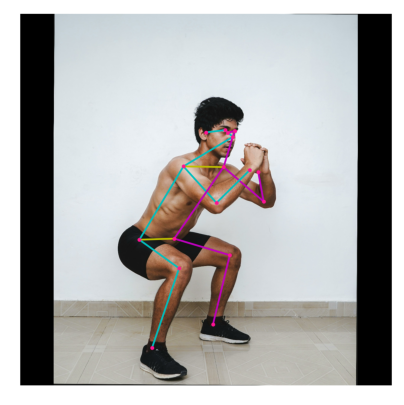

In [ ]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

## Video (Image Sequence) Example

This section demonstrates how to apply intelligent cropping based on detections from the previous frame when the input is a sequence of frames. This allows the model to devote its attention and resources to the main subject, resulting in much better prediction quality without sacrificing the speed.


In [15]:
#@title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inference on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores

In [ ]:
np.shape(keypoints_with_scores[0])

(1, 17, 3)

### Load Input Image Sequence

In [ ]:
!wget -q -O dance.gif https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/dance_input.gif

In [16]:
input_vid = 'input/ablume_walking.gif'

In [17]:
# Load the input image.
input_vid = 'input/ablume_walking.gif'
image = tf.io.read_file(input_vid)
image = tf.image.decode_gif(image)

### Run Inference with Cropping Algorithm

In [18]:
# Load the input image.
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)

output_images = []
bar = display(progress(0, num_frames-1), display_id=True)
kps_final=[]

for frame_idx in range(num_frames):
#   print(frame_idx)
  keypoints_with_scores = run_inference(
      movenet, image[frame_idx, :, :, :], crop_region,
      crop_size=[input_size, input_size])

  kps_final.append(keypoints_with_scores[0][0])

  output_images.append(draw_prediction_on_image(
      image[frame_idx, :, :, :].numpy().astype(np.int32),
      keypoints_with_scores, crop_region=None,
      close_figure=True, output_image_height=300))
  crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
  bar.update(progress(frame_idx, num_frames-1))

In [28]:
# Prepare gif visualization.
output = np.stack(output_images, axis=0)
to_gif(output, duration=100, dest="static/2025-08-18_22-07-41.mp4")

static/2025-08-18_22-07-41.mp4


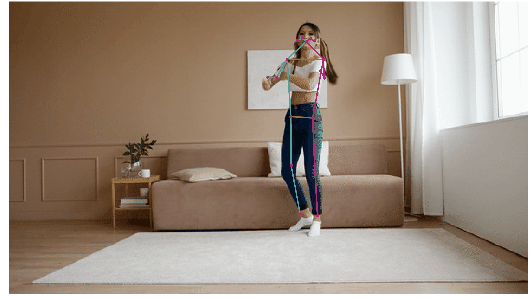

In [ ]:
output_vid = "output/animation.gif"
display(Image(filename=output_vid))

In [ ]:
html_code = f"""
<table>
  <tr>
    <th>Input Video</th>
    <th>Output Video</th>
  </tr>
  <tr>
    <td><img src="{input_vid}" width="500"></td>
    <td><img src="{output_vid}" width="500"></td>
  </tr>
</table>
"""

display(HTML(html_code))

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def load_video_as_tensor(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)

    cap.release()
    video_tensor = tf.convert_to_tensor(np.array(frames), dtype=tf.uint8)
    return video_tensor  # shape: (num_frames, height, width, 3)

In [ ]:
# Example usage:
video_tensor = load_video_as_tensor("D:\Projects\TALES OF RAJ\Exports\Scene 1.mp4")
print(video_tensor.shape)

MemoryError: Unable to allocate 14.5 GiB for an array with shape (2505, 1080, 1920, 3) and data type uint8

In [ ]:
# Load the input image.
input_vid = 'D:\Projects\TALES OF RAJ\Exports\Scene 1.mp4'
image = tf.io.read_file(input_vid)
image = tf.image.decode_gif(image)

InvalidArgumentError: {{function_node __wrapped__DecodeGif_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeGif]

## Image FN

In [ ]:
def img_segment(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(display_image, 1920, 1080), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

    return output_overlay

    # plt.figure(figsize=(5, 5))
    # plt.imshow(output_overlay)
    # _ = plt.axis('off')

In [ ]:
def process_video(video_path):

    output_video_path = "output/output_"+os.path.splitext(os.path.basename(video_path))[0]+".mp4"

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video")
        return

    # Get original video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = 1920
    frame_height = 1080

    # Define video writer
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    frame_id = 0
    temp_dir = "frames/"+os.path.basename(video_path)
    os.makedirs(temp_dir, exist_ok=True)

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Stop when video ends

        temp_path = os.path.join(temp_dir, f"frame_{frame_id:06d}.jpg")
        # cv2.imwrite(temp_path, frame)

        # Process frame
        segmented_rgb = img_segment(temp_path)

        # Convert RGB to BGR (OpenCV uses BGR)
        segmented_bgr = cv2.cvtColor(segmented_rgb, cv2.COLOR_RGB2BGR)
        cv2.imwrite(temp_path, segmented_bgr)
        out_writer.write(segmented_bgr)

        frame_id += 1

    cap.release()
    out_writer.release()
    print(f"Processed video saved as {output_video_path}")

In [ ]:
video_path = "input/dance_input.gif"
process_video(video_path)

Processed video saved as output/output_dance_input.mp4


## Vide FN

In [ ]:
def process_video_with_movenet(video_path, movenet, input_size, draw_prediction_on_image):
    """
    Processes an MP4 video frame-by-frame using MoveNet and returns a list of images
    with pose keypoints drawn.

    Args:
        video_path (str): Path to the input MP4 video.
        movenet (tf.function): Loaded MoveNet model.
        input_size (int): Expected input size for MoveNet (e.g., 192 or 256).
        draw_prediction_on_image (function): Function to draw keypoints.

    Returns:
        List[np.ndarray]: Frames with pose overlays.
    """

    # Open the video file using OpenCV
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {video_path}")

    # Read the first frame to get dimensions
    ret, frame = cap.read()
    if not ret:
        raise IOError("Unable to read video frames.")
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = frame.shape
    crop_region = init_crop_region(image_height, image_width)

    # Prepare list to store output
    output_frames = []
    frame_idx = 0

    os.makedirs("frames/TOR", exist_ok=True)

    while ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Run inference and get keypoints
        keypoints_with_scores = run_inference(
            movenet, frame_rgb, crop_region, crop_size=[input_size, input_size])

        # Draw predictions on the image
        output_image = draw_prediction_on_image(
            frame_rgb.astype(np.int32),
            keypoints_with_scores,
            crop_region=None,
            close_figure=True,
            output_image_height=300
        )
        output_frames.append(output_image)
        cv2.imwrite(f"frames/TOR/frame_{frame_idx:06d}.png", cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))

        # Update crop region for next frame
        crop_region = determine_crop_region(keypoints_with_scores, image_height, image_width)

        # Read next frame
        ret, frame = cap.read()
        frame_idx += 1

    cap.release()
    return output_frames


KeyboardInterrupt: 

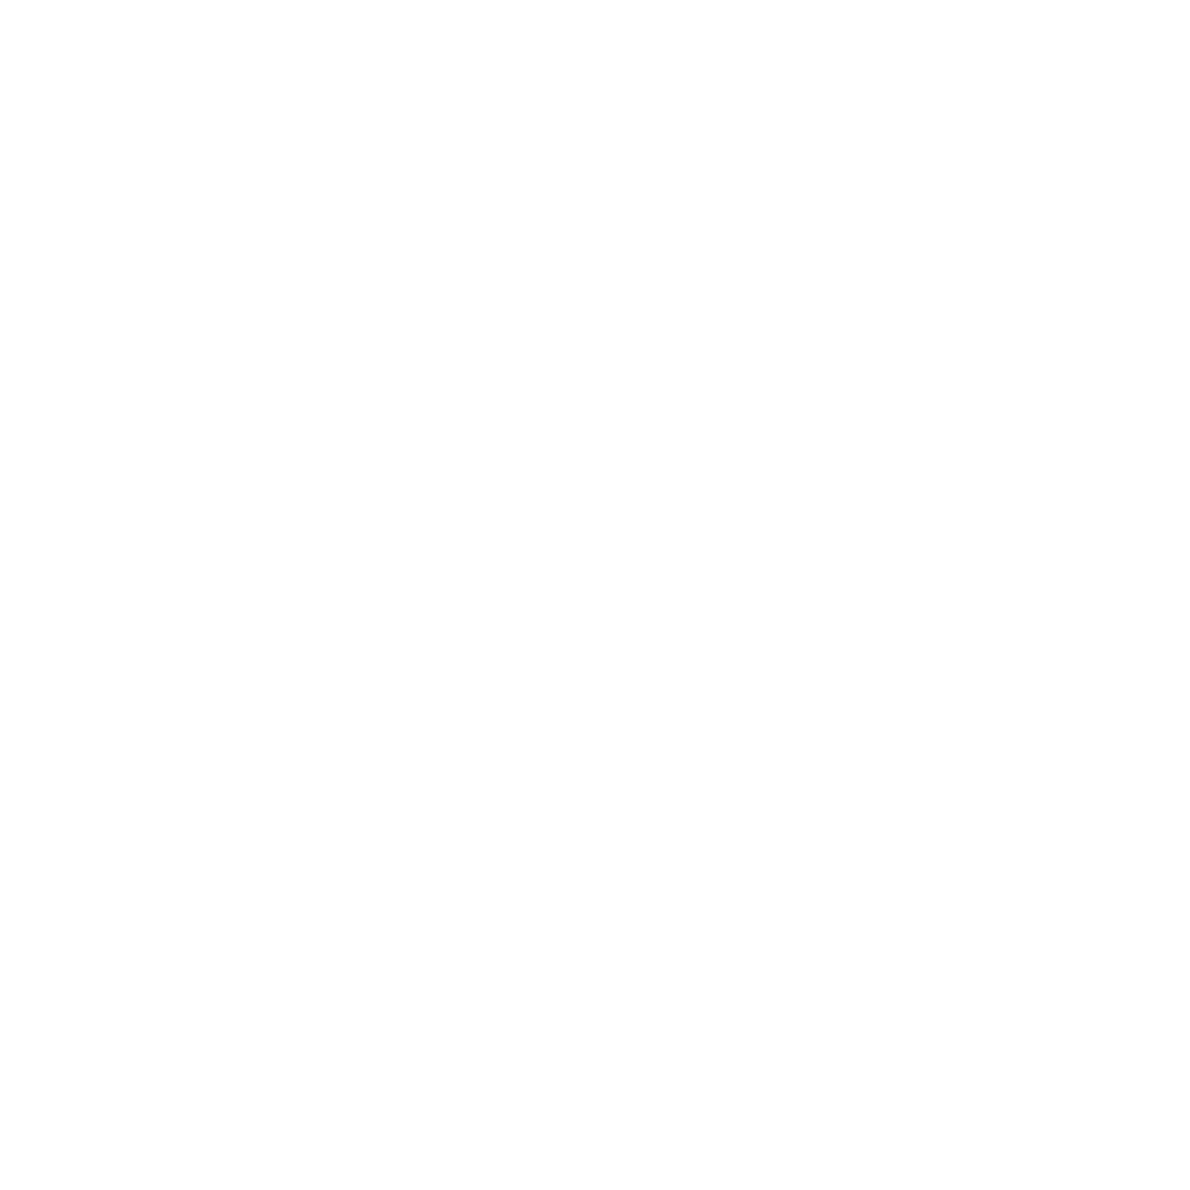

In [ ]:
video_path = 'D:\Projects\TALES OF RAJ\Footage\Scene 1\SCENE 1\Video\MVI_4864.MP4'
# video_path = 'input/dance_input.gif'
video_path = 'D:\Projects\TALES OF RAJ\Exports\Scene 1.mp4'
output_frames = process_video_with_movenet(video_path, movenet, input_size, draw_prediction_on_image)

# imageio.mimsave("pose_output.mp4", output_frames, duration=0.03)

In [ ]:
print(output_frames)

In [ ]:
output = np.stack(output_frames, axis=0)

In [ ]:
display(output)

In [ ]:
writer = imageio.get_writer('output.mp4', fps=24)

for im in output_frames:
    writer.append_data(imageio.imread(im))
writer.close()

C:\Users\Intel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  after removing the cwd from sys.path.


OSError: Cannot understand given URI: array([[[255, 255, 255],
        [255, 255, 255],
       ....

In [ ]:
!pip install imageio[ffmpeg]

   ---------------------------------------- 22.6/22.6 MB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install imageio[pyav]

In [ ]:
imageio.mimsave("pose_output.mp4", output_frames)